<a href="https://colab.research.google.com/github/jyanivaddi/ERA_V1/blob/master/session_13/S13_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First Connect Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


Install packages

In [3]:
!git clone "https://github.com/jyanivaddi/ERA_V1.git"
!git -C ERA_V1 pull
#!cd ../
!git clone "https://github.com/jyanivaddi/dl_hub.git"
!git -C dl_hub pull
!git pull
#!cd ../

!pip install --quiet "torchinfo" "seaborn" "pytorch-lightning" "torchmetrics" "lightning-bolts"
!pip install --quiet "prettytable"
!pip install --quiet "torchsummary"
!pip install --quiet "torch_lr_finder"
!pip install --quiet "grad-cam"
!pip install --quiet "gradio"

fatal: destination path 'ERA_V1' already exists and is not an empty directory.
Already up to date.
fatal: destination path 'dl_hub' already exists and is not an empty directory.
Already up to date.
fatal: not a git repository (or any of the parent directories): .git


In [4]:
import sys
sys.path.append("ERA_V1/session_13")
sys.path.append("dl_hub")

In [5]:
!git -C dl_hub pull


Already up to date.


In [6]:
import dl_hub.YOLO_V3.config as config
import torch
import torch.optim as optim
import os
from dl_hub.YOLO_V3.model import YOLOv3
from tqdm import tqdm
from dl_hub.YOLO_V3.yolo_v3_utils.utils import (
    mean_average_precision,
    cells_to_bboxes,
    get_evaluation_bboxes,
    save_checkpoint,
    load_checkpoint,
    check_class_accuracy,
    get_loaders,
    plot_couple_examples
)
from dl_hub.YOLO_V3.yolo_v3_utils.loss import YoloLoss
from dl_hub.YOLO_V3.PL_model import LitYOLOv3
from dl_hub.YOLO_V3.yolo_v3_utils.PL_data_module import YOLODataModule
from dl_hub.PL_main import train_and_eval_pl_model
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/usr/local/lib/python3.10/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:92: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  contrastive_task: Union[FeatureMapContrastiveTask] = FeatureMapCon

In [7]:
print(config.DATASET)


/content/gdrive/MyDrive/Datasets/PASCAL_VOC_SMALL


**Define Data Module**

In [7]:
# Define data module
#csv_files = [os.path.join(config.DATASET, "100examples.csv"),os.path.join(config.DATASET,"8examples.csv")]
csv_files = [os.path.join(config.DATASET, "train.csv"),os.path.join(config.DATASET,"test.csv")]
train_transforms=config.train_transforms
test_transforms=config.test_transforms
val_transforms = test_transforms
IMAGE_SIZE = config.IMAGE_SIZE
S=[IMAGE_SIZE // 32, IMAGE_SIZE // 16, IMAGE_SIZE // 8]
img_dir=config.IMG_DIR
label_dir=config.LABEL_DIR
anchors=config.ANCHORS
batch_size = 8
yolo_dm = YOLODataModule(
    csv_files,
    img_dir,
    label_dir,
    anchors,
    batch_size,
    image_size=IMAGE_SIZE,
    S=S,
    C=20,
    train_transforms = train_transforms,
    val_transforms = val_transforms,
    test_transforms = test_transforms,
    val_split=0.1,
    num_workers = config.NUM_WORKERS,
    use_mosaic_on_train=True,
    mosaic_probability=0.75,
    pin_memory = False)
yolo_dm.prepare_data()
yolo_dm.setup()

**Identify best LR**

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.87E-02


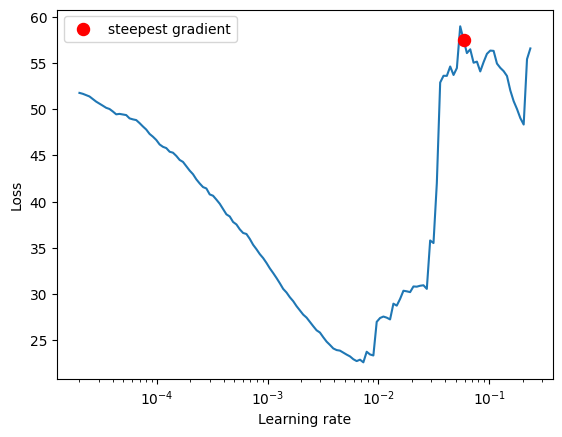

In [ ]:
from torch_lr_finder import LRFinder

# Define model parameters
scaled_anchors = (
    torch.tensor(config.ANCHORS)
    * torch.tensor(config.S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
).to(config.DEVICE)
loss_fn = YoloLoss()
conf_threshold = config.CONF_THRESHOLD
EPOCHS = config.NUM_EPOCHS * 2 // 5

# Define Model
dummy_yolo_model = LitYOLOv3(loss_fn, scaled_anchors,conf_threshold, optimizer=None, scheduler_dict=None, num_classes=20, epochs=EPOCHS)
optimizer = optim.Adam(dummy_yolo_model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY)
train_data_loader = yolo_dm.train_dataloader()

def criterion(out, y):
    y0, y1, y2 = (
            y[0].to(config.DEVICE),
            y[1].to(config.DEVICE),
            y[2].to(config.DEVICE),
        )
    loss = (
                loss_fn(out[0], y0, scaled_anchors[0])
                + loss_fn(out[1], y1, scaled_anchors[1])
                + loss_fn(out[2], y2, scaled_anchors[2])
            )
    return loss
lr_finder = LRFinder(dummy_yolo_model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_data_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [ ]:
max_lr = 8E-4

**Load trained model**

In [8]:
model_path = "/content/gdrive/MyDrive/trained_models/YOLOv3/75_mosaic_checkpoint_epoch_39_step_74480.ckpt"

In [9]:
from torch.optim.lr_scheduler import OneCycleLR
# Define model parameters
scaled_anchors = (
    torch.tensor(config.ANCHORS)
    * torch.tensor(config.S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
).to(config.DEVICE)
train_data_loader = yolo_dm.train_dataloader()
test_data_loader = yolo_dm.test_dataloader()
# Define Model
yolo_model_trained = LitYOLOv3.load_from_checkpoint(model_path)


**Define the targets for GradCAM**

In [40]:
import torchvision
from dl_hub.YOLO_V3.yolo_v3_utils.utils import non_max_suppression
from pytorch_grad_cam import AblationCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_cam_image
from PIL import Image
import cv2

# This will help us create a different color for each class
COLORS = np.random.uniform(0, 255, size=(len(config.PASCAL_CLASSES), 3))

class YOLOv3Target:
    """ For every original detected bounding box specified in "bounding boxes",
    	assign a score on how the current bounding boxes match it,
    		1. In IOU
    		2. In the classification score.
    	If there is not a large enough overlap, or the category changed,
    	assign a score of 0.

    	The total score is the sum of all the box scores.
    """

    def __init__(self, iou_threshold=0.45, threshold=0.25):
        self.iou_threshold = iou_threshold
        self.threshold = threshold
        self.device = "cuda" if torch.cuda.is_available() else "cpu"


    def _get_boxes_from_prediction(self, predictions):
        bboxes = [[] for _ in range(len(predictions))]
        for i in range(3):
            S = predictions[i].shape[2]
            anchor = torch.tensor([*self.anchors[i]]).to(self.device) * S
            boxes_scale_i = cells_to_bboxes(
                predictions[i], anchor, S=S, is_preds=True
            )
            for idx, (box) in enumerate(boxes_scale_i):
                bboxes[idx] += box

        for idx in range(len(predictions)):
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=self.iou_threshold,
                threshold=self.threshold,
                box_format='midpoint',
            )
        return nms_boxes

    def __call__(self, model_outputs):
        all_pred_boxes = []
        all_true_boxes = []
        output = torch.Tensor([0])
        if torch.cuda.is_available():
            output = output.cuda()

        nms_boxes = self._get_boxes_from_prediction(model_outputs)
        print("nms boxes on the prediction: ")
        print(nms_boxes)
        "box should contain class pred, confidence, x, y, width, height"
        for cnt in range(nms_boxes.shape[0]):
            output = output + nms_boxes[1, cnt]
        return output

def draw_boxes(boxes, labels, classes, image):
    for i, box in enumerate(boxes):
        color = COLORS[labels[i]]
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, 2
        )
        cv2.putText(image, classes[i], (int(box[0]), int(box[1] - 5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2,
                    lineType=cv2.LINE_AA)
    return image

def renormalize_cam_in_bounding_boxes(boxes, image_float_np, grayscale_cam, labels, classes):
    """Normalize the CAM to be in the range [0, 1]
    inside every bounding boxes, and zero outside of the bounding boxes. """
    renormalized_cam = np.zeros(grayscale_cam.shape, dtype=np.float32)
    images = []
    for x1, y1, x2, y2 in boxes:
        img = renormalized_cam * 0
        img[y1:y2, x1:x2] = scale_cam_image(grayscale_cam[y1:y2, x1:x2].copy())
        images.append(img)

    renormalized_cam = np.max(np.float32(images), axis = 0)
    renormalized_cam = scale_cam_image(renormalized_cam)
    eigencam_image_renormalized = show_cam_on_image(image_float_np, renormalized_cam, use_rgb=True)
    image_with_bounding_boxes = draw_boxes(boxes, labels, classes, eigencam_image_renormalized)
    return image_with_bounding_boxes



In [50]:
import numpy as np

def convert_to_np_float_array(x):
    input_np = np.asarray(x)
    input_float_np = np.float32(input_np) / 255
    return input_float_np

def get_labels(boxes):
    """Plots predicted bounding boxes on the image"""
    cmap = plt.get_cmap("tab20b")
    class_labels = config.COCO_LABELS if config.DATASET=='COCO' else config.PASCAL_CLASSES
    all_class_names = []
    all_class_labels = []
    for box in boxes:
        assert len(box) == 6, "box should contain class pred, confidence, x, y, width, height"
        class_pred = box[0]
        class_name = class_labels[int(class_pred)]
        all_class_names.append(class_name)
        class_label = int(class_pred)
        all_class_labels.append(class_label)
    return all_class_names, all_class_labels

def predict(model, loader, anchors, device, thresh=0.6, iou_thresh=0.5):
    model.eval()
    x, y = next(iter(loader))
    x = x[0].unsqueeze(0)
    y = y[0].unsqueeze(0)
    x = x.to(device)
    with torch.no_grad():
        out = model(x)
        bboxes = [[] for _ in range(x.shape[0])]
        for i in range(3):
            batch_size, A, S, _, _ = out[i].shape
            anchor = anchors[i]
            boxes_scale_i = cells_to_bboxes(
                out[i], anchor, S=S, is_preds=True
            )
            for idx, (box) in enumerate(boxes_scale_i):
                bboxes[idx] += box

    nms_boxes = non_max_suppression(bboxes, iou_threshold=iou_thresh, threshold=thresh, box_format="midpoint")
    classes, labels = get_labels(nms_boxes)
    x_np_float_array = convert_to_np_float_array(x)
    return x, x_np_float_array, nms_boxes, classes, labels


In [51]:
# Target layer for lowest scale prediction: yolo_model_trained.model.layers[-1].pred[0]
# Target layer for 2nd lowest scale prediction: yolo_model_trained.model.layers[22].pred[0]
# Target layer for highest scale prediction: yolo_model_trained.model.layers[15].pred[0]
target_layers = [yolo_model_trained.model.layers[-1].pred[1]]
targets = [YOLOv3Target()]
cam = EigenCAM(yolo_model_trained,
               target_layers,
               use_cuda=torch.cuda.is_available(),
               reshape_transform=None)
input_tensor, image_float_np, boxes, classes, labels = predict(yolo_model_trained,
                                                               test_data_loader,
                                                               scaled_anchors,
                                                               device = config.DEVICE)
#grayscale_cam = cam(input_tensor, targets=targets)
#print(grayscale_cam.shape)
# Take the first image in the batch:
#grayscale_cam = grayscale_cam[0, :]
#cam_image = show_cam_on_image(input_np.T, grayscale_cam, use_rgb=True)
#Image.fromarray(renormalize_cam_in_bounding_boxes(boxes, image_float_np, grayscale_cam, labels, classes))
# And lets draw the boxes again:
#image_with_bounding_boxes = draw_boxes(boxes, labels, classes, cam_image)
#Image.fromarray(image_with_bounding_boxes)

TypeError: ignored

In [45]:
cam_image.shape

(416, 416, 3)

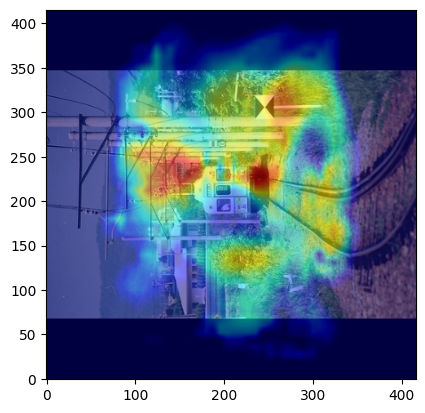

In [39]:
import matplotlib.pyplot as plt
plt.imshow(cam_image,origin='lower')
plt.show()

In [37]:
yolo_model_trained.model.layers[15].pred[0]

CNNBlock(
  (conv): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leaky): LeakyReLU(negative_slope=0.1)
)

In [23]:
import torchinfo

def model_summary(model, input_size):
    torchinfo.summary(model,
                      input_size = input_size,
                      batch_dim=0,
                      col_names=("kernel_size",
                                 "input_size",
                                 "output_size",
                                 "num_params",
                                 "mult_adds"),
                       verbose=1,)

model_summary(yolo_model_trained, (3, 416, 416))

Layer (type:depth-idx)                                  Kernel Shape              Input Shape               Output Shape              Param #                   Mult-Adds
LitYOLOv3                                               --                        [1, 3, 416, 416]          [1, 3, 13, 13, 25]        --                        --
├─YOLOv3: 1-1                                           --                        --                        --                        --                        --
│    └─ModuleList: 2-1                                  --                        --                        --                        --                        --
│    │    └─CNNBlock: 3-1                               --                        [1, 3, 416, 416]          [1, 32, 416, 416]         928                       149,520,448
│    │    └─CNNBlock: 3-2                               --                        [1, 32, 416, 416]         [1, 64, 208, 208]         18,560                    797,442,1